In [21]:
import numpy as np
import matplotlib.pyplot as plot

%matplotlib inline

In [346]:

class BaseIntegrator(object):
    def __init__(self):
        self.n_steps = 0
        
    def integrate(self, dydx, y0, x0, x_max, dx0):
        y_ = y0
        y = [y0,]
        x_ = x0
        x = [x0,]
        dx = dx0
        
        while x_ < x_max:
            try:
                if x_ + dx > x_max:
                    dx = x_max - x_
                dy, dx = self.dy(dydx=dydx, y=y_, dx=dx, x=x_)
                y_ += dy
                x_ += dx
                y.append(y_)
                x.append(x_)
            except Exception as e:
                print str(e)
                break
            
        return np.array(x), np.array(y)
    
    def integrate_and_plot(self, plot, dydx, y0, x0, x_max, dx0):
        res = self.integrate(dydx=dydx, y0=y0, x0=x0, dx0=dx0, x_max=x_max)
        label = "%s: %d steps" % (str(self), self.n_steps)
        plot.plot(*res, marker='s', linestyle='', label=label)
        
    def __str__(self):
        return self.__class__.__name__


In [347]:
class EulerForward(BaseIntegrator):
    def dy(self, dydx, y, x, dx):
        self.n_steps += 1

        return dydx(y=y, x=x)*dx, dx
    
class AdaptiveIntegrator(BaseIntegrator):
    def __init__(self, abs_tol=1.0e-3, rel_tol=1.0e-3, scale_f=None):
        super(AdaptiveIntegrator, self).__init__()
        if scale_f is None:
            scale_f = lambda abs_err, abs_tol: 0.84*(abs_tol/abs_err)**0.25
        self.scale_f = scale_f
        self.abs_tol = abs_tol
        self.rel_tol = rel_tol
        self.n_max = 100
    
class RKF34(AdaptiveIntegrator):
    """Runge-Kutta-Fehlberg integrator with coefficients given in DeuflHard & Borneman
    """ 
    def dy(self, dydx, y, x, dx, n=0):
        self.n_steps += 1
        k1 = dx*dydx(x=x, y=y)
        k2 = dx*dydx(x=x+.5*dx, y=y+.5*k1)
        k3 = dx*dydx(x=x+.5*dx, y=y+.5*k2)
        k4 = dx*dydx(x=x+dx,    y=y+   k3)
        y_n = y + 1./6.*(k1+k4) + 1./3.*(k2+k3)
        k5 = dx*dydx(x=x+dx,    y=y_n)
    
        abs_err = abs(1./6.*(k4 - k5))
        
        if y != 0.0 and abs_err/y < self.rel_tol:
            return y_n-y, dx
        elif abs_err < self.abs_tol:
            return y_n-y, dx
        else:
            if n > self.n_max:
                raise Exception("Error when adjusting step size")
            dx *= self.scale_f(abs_err=abs_err, abs_tol=self.abs_tol)
            return self.dy(dydx=dydx, y=y, x=x, dx=dx, n=n+1)
 
    
class RKF34_original(AdaptiveIntegrator):
    """Original Runge-Kutta-Fehlberg method as given in Fehlberg 1970""" 
    def dy(self, dydx, y, x, dx, n=0):
        self.n_steps += 1
        k1 = dx*dydx(x=x, y=y)
        k2 = dx*dydx(x=x+2./7.*dx,  y=y+2./7.*k1)
        k3 = dx*dydx(x=x+7./15.*dx, y=y+77./900.*k1 + 343./900.*k2)
        k4 = dx*dydx(x=x+35./38.*dx, y=y+805./1444.*k1 - 77175./54872.*k2 + 97125./54872.*k3)
        k5 = dx*dydx(x=x+dx, y=y + 79./490.*k1 + 2175./3616.*k3 + 2166./9065.*k4)
    
        y_n1 = y + 79./490.*k1 + 2175./3626.*k3 + 2166./9065.*k4
        y_n2 = y + 229./1470.*k1 + 1125./1813.*k3 + 13718./81585.*k4 + 1./18.*k5
    
        abs_err = abs(y_n1 - y_n2)
        
        if y != 0.0 and abs_err/y < self.rel_tol:
            return y_n2-y, dx
        elif abs_err < self.abs_tol:
            return y_n2-y, dx
        else:
            if n > self.n_max:
                raise Exception("Error when adjusting step size")
            dx *= self.scale_f(abs_err=abs_err, abs_tol=self.abs_tol)
            return self.dy(dydx=dydx, y=y, x=x, dx=dx, n=n+1)

class RKF45(AdaptiveIntegrator):
    def dy(self, dydx, y, x, dx, n=0):
        self.n_steps += 1
        k1 = dx*dydx(x=x, y=y)
        k2 = dx*dydx(x=x+.25*dx, y=y+.25*k1)
        k3 = dx*dydx(x=x+3./8.*dx, y=y+3./32.*k1 + 9./32.*k2)
        k4 = dx*dydx(x=x+12./13.*dx,    y=y + 1932./2197.*k1 - 7200./2197.*k2 + 7296./2197.*k3)
        k5 = dx*dydx(x=x+dx,    y=y + 439./216.*k1 - 8.*k2 + 3680./513*k3 - 845./4104.*k4)
        k6 = dx*dydx(x=x+.5*dx,  y=y - 8./27.*k1 + 2.*k2 - 3544./2565.*k3 + 1859./4104.*k4 - 11./40.*k5)
    
        y_n1 = y + 25./216.*k1 + 1408./2565.*k3 + 2196./4101.*k4 - 0.2*k5
        y_n2 = y + 16./135.*k1 + 6656./12825.*k3 + 28561./56430.*k4 - 9./50.*k5 + 2./55*k6
    
        abs_err = abs(y_n1 - y_n2)

        
        if y != 0.0 and abs_err/y < self.rel_tol:
            return y_n2-y, dx
        elif abs_err < self.abs_tol:
            return y_n2-y, dx
        else:
            if n > self.n_max:
                raise Exception("Error when adjusting step size")
            s = self.scale_f(abs_err=abs_err, abs_tol=self.abs_tol)
            # print dx, abs_err, s
            dx = dx*s
            return self.dy(dydx=dydx, y=y, x=x, dx=dx, n=n+1)

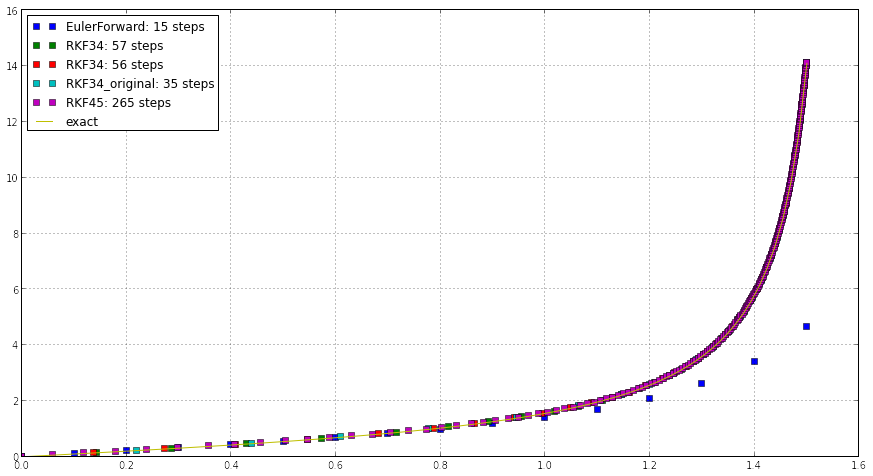

In [350]:
dydx = lambda x, y: 1.+y**2.
y_exact = lambda x: np.tan(x)
x_max = 1.5
y0 = 0.0
x0 = 0.0

fig = plot.figure(figsize=(15,8))
EulerForward().integrate_and_plot(plot=plot, dydx=dydx, y0=y0, x0=x0, dx0=0.1, x_max=x_max)

RKF34(abs_tol=abs_tol, rel_tol=rel_tol).integrate_and_plot(plot=plot, dydx=dydx, y0=y0, x0=x0, dx0=0.4, x_max=x_max)
abs_tol, rel_tol = 1.0e-5, 1.0e-7
scale_f = lambda abs_err, abs_tol: 0.8*(abs_tol/abs_err)**0.25
RKF34(abs_tol=abs_tol, rel_tol=rel_tol, scale_f=scale_f).integrate_and_plot(plot=plot, dydx=dydx, y0=y0, x0=x0, dx0=0.4, x_max=x_max)

RKF34_original(abs_tol=abs_tol, rel_tol=rel_tol).integrate_and_plot(plot=plot, dydx=dydx, y0=y0, x0=x0, dx0=0.4, x_max=x_max)

RKF45(abs_tol=abs_tol, rel_tol=rel_tol).integrate_and_plot(plot=plot, dydx=dydx, y0=y0, x0=x0, dx0=0.4, x_max=x_max)


x2 = np.linspace(0., x_max, 100)
plot.plot(x2, y_exact(x2,), label='exact')
plot.grid(True)
plot.legend(loc="upper left")